In [1]:
import numpy as np
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

In [3]:
IMAGE_WIDTH = 180
IMAGE_HEIGHT = 180
IMAGE_CHANNELS = 3
DATASET_DIR = "./dataset/"
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
NUM_CLASSES = 2
EPOCHS = 25

In [206]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR + "train", 
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    seed=645)

class_names = train_ds.class_names

Found 5032 files belonging to 2 classes.


In [207]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR + "val", 
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    seed=845)

Found 200 files belonging to 2 classes.


In [208]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR + "test", 
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    seed=321)

Found 624 files belonging to 2 classes.


In [209]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    layers.experimental.preprocessing.RandomRotation(15),
    layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
    layers.experimental.preprocessing.RandomZoom(height_factor=0.15, width_factor=0.15),

    layers.Conv2D(4, 3, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(8, 3, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(16, 3, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(64),
    layers.ReLU(),
    layers.Dense(128),
    layers.ReLU(),
    layers.Dense(NUM_CLASSES)
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 4)       112       
_________________________________________________________________
re_lu (ReLU)                 (None, 180, 180, 4)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 4)         0

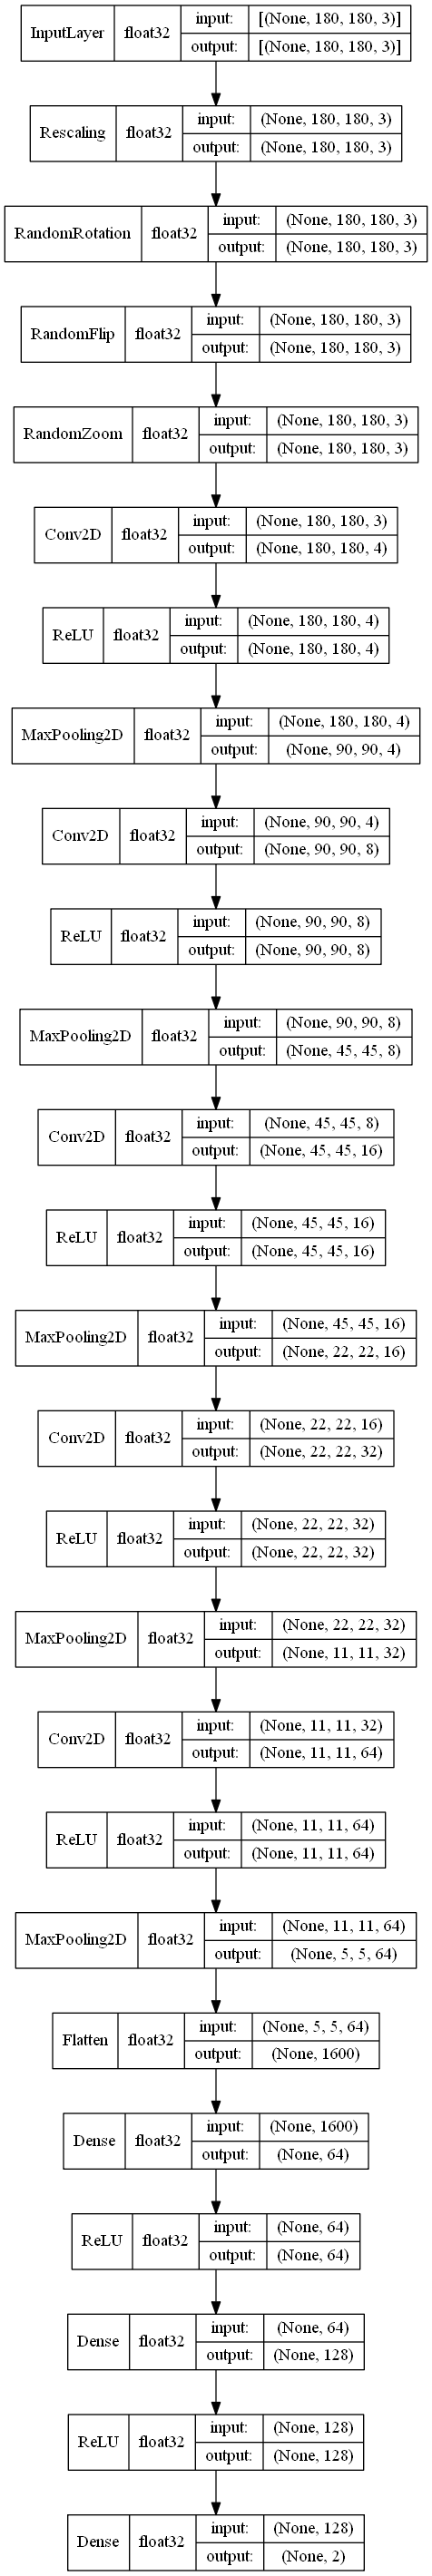

In [7]:
tf.keras.utils.plot_model(
    model,
    to_file="cnn.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [195]:
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(train_ds,
          validation_data=val_ds,
          callbacks=[early_stopping_monitor],
          epochs=50)

Epoch 1/50
158/158 [==============================] - 8s 44ms/step - loss: 0.5683 - accuracy: 0.7394 - val_loss: 0.3242 - val_accuracy: 0.8600
Epoch 2/50
158/158 [==============================] - 5s 32ms/step - loss: 0.3438 - accuracy: 0.8565 - val_loss: 0.2362 - val_accuracy: 0.9250
Epoch 3/50
158/158 [==============================] - 5s 30ms/step - loss: 0.2418 - accuracy: 0.8978 - val_loss: 0.2463 - val_accuracy: 0.9050
Epoch 4/50
158/158 [==============================] - 5s 31ms/step - loss: 0.2219 - accuracy: 0.9092 - val_loss: 0.2380 - val_accuracy: 0.9200
Epoch 5/50
158/158 [==============================] - 5s 33ms/step - loss: 0.2245 - accuracy: 0.9132 - val_loss: 0.2297 - val_accuracy: 0.9200
Epoch 6/50
158/158 [==============================] - 5s 34ms/step - loss: 0.1863 - accuracy: 0.9233 - val_loss: 0.2274 - val_accuracy: 0.9100
Epoch 7/50
158/158 [==============================] - 5s 32ms/step - loss: 0.1771 - accuracy: 0.9290 - val_loss: 0.2011 - val_accuracy: 0.9300

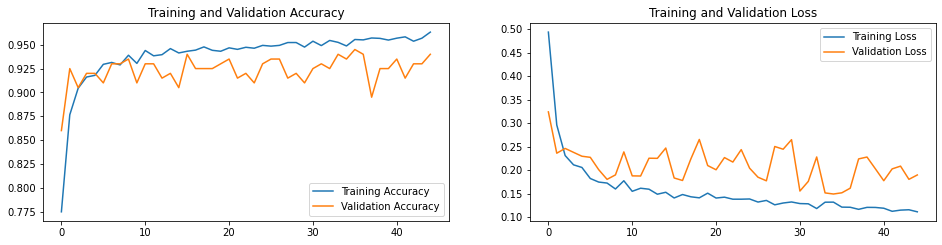

In [196]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(45)

plt.figure(figsize=(16, 8))
plt.subplot(2,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [197]:
model.evaluate(test_ds)

20/20 [==============================] - 11s 358ms/step - loss: 0.2971 - accuracy: 0.8846


[0.2970917522907257, 0.8846153616905212]